### PRUEBA_GERENTE_MODELOS_RIESGO_CREDITO
    Humberto Ortiz Espinosa

#### Libreras y extraccion de datos (ELD)

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_percentage_error

In [83]:
archivo_excel = 'PRUEBA_MODELOS_RIESGOS.xlsx'

hojas = pd.read_excel(archivo_excel, sheet_name=None)
for nombre_hoja, datos in hojas.items():
    globals()[nombre_hoja] = datos
# Nombre de los DF: VARIACION_MENSUAL, VARIACION_TRIMESTRE, SERIE_OBJETIVO, TASAS_DE_CETES

# Convertir las fechas de SERIE OBJETIVO
SERIE_OBJETIVO['Fecha'] = pd.to_datetime(
    SERIE_OBJETIVO['Fecha'], format='%b %Y', errors='coerce'
)

# Convertir las fechas de SERIES EXTERNAS
VARIACION_MENSUAL['Fecha'] = pd.to_datetime(
    VARIACION_MENSUAL['Fecha'], format='%b %Y', errors='coerce'
)

# Verificar que no haya valores nulos después de la conversión
if SERIE_OBJETIVO['Fecha'].isnull().any() or VARIACION_MENSUAL['Fecha'].isnull().any():
    print("Algunas fechas no se pudieron convertir. Revisa el formato.")


#### Calculo SERIE OBETIVO (IMORA_YOY) y Outliers

In [84]:
serie_objetivo = SERIE_OBJETIVO.sort_values(by='Fecha')
serie_objetivo['IMORA_YoY'] = serie_objetivo['Índice de Morosidad (IMORA)'].pct_change(periods=12) * 100 # Revisar periodos a revisar segun instrucciones 


In [85]:
# Definir los límites inferior y superior para detectar outliers
Q1 = serie_objetivo['IMORA_YoY'].quantile(0.25)
Q3 = serie_objetivo['IMORA_YoY'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = serie_objetivo[(serie_objetivo['IMORA_YoY'] < lower_bound) | (serie_objetivo['IMORA_YoY'] > upper_bound)]  # Detectar outliers
print('Outliears detectados', outliers)


Outliears detectados         Fecha  Índice de Morosidad (IMORA)  IMORA_YoY
43 2007-07-01                     4.259983  46.152052
44 2007-08-01                     4.334365  44.939596
45 2007-09-01                     4.473663  48.950559
46 2007-10-01                     4.652233  53.865054
47 2007-11-01                     4.788354  54.988594
48 2007-12-01                     5.030441  67.869268
49 2008-01-01                     5.142946  61.041561
50 2008-02-01                     5.263942  57.524669
51 2008-03-01                     5.232231  49.647820
52 2008-04-01                     5.503238  48.557772
63 2009-03-01                     7.557839  44.447732
64 2009-04-01                     7.990597  45.198100
65 2009-05-01                     8.419149  49.158295
66 2009-06-01                     8.607025  51.143813
67 2009-07-01                     8.667510  48.351820
68 2009-08-01                     8.844459  48.714654


#### Transformaciones y Regresiones (log, r2, boxcox, promedio movil, exponencial... )

In [86]:
# Asegurarse de que 'Fecha' esté en formato numérico (por ejemplo, número de días desde el inicio)
serie_objetivo['Fecha_numerica'] = (serie_objetivo['Fecha'] - serie_objetivo['Fecha'].min()).dt.days

# Transformación Logarítmica
serie_objetivo['IMORA_YoY_log'] = np.log1p(serie_objetivo['Índice de Morosidad (IMORA)'])

# Transformación Box-Cox
serie_objetivo['IMORA_YoY_boxcox'], lambda_ = stats.boxcox(serie_objetivo['Índice de Morosidad (IMORA)'] + 1)  # Asegúrate de que no haya ceros o valores negativos

# Raíz cuadrada
serie_objetivo['IMORA_YoY_sqrt'] = np.sqrt(serie_objetivo['Índice de Morosidad (IMORA)'] + 1)

# linea de Tendencia 
X = serie_objetivo[['Fecha_numerica']]
y = serie_objetivo['Índice de Morosidad (IMORA)']
model = LinearRegression().fit(X, y)
serie_objetivo['IMORA_Predicho'] = model.predict(X)

# Regresión Polinómica
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
model_poly = LinearRegression().fit(X_poly, y)
serie_objetivo['IMORA_Predicho_Poly'] = model_poly.predict(X_poly)



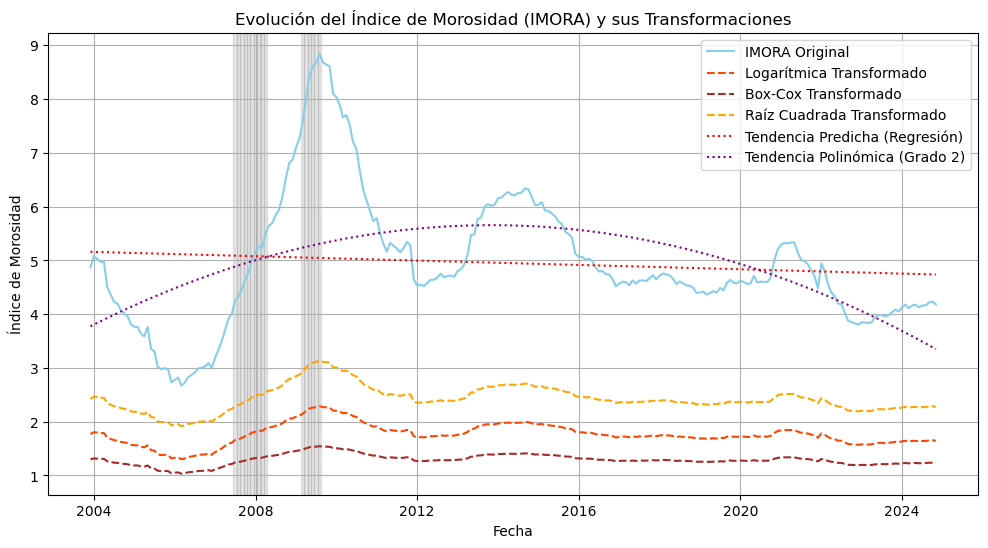

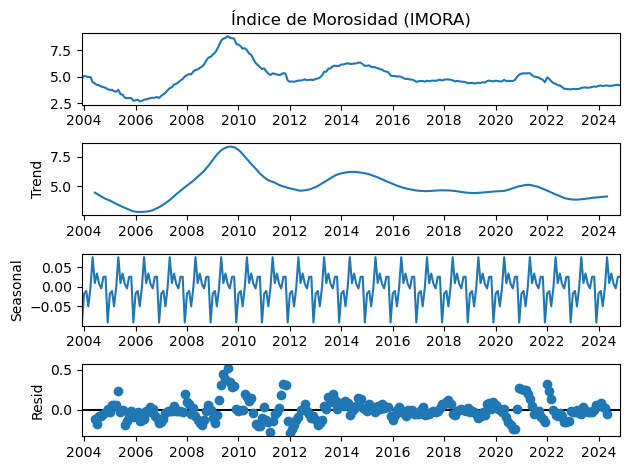

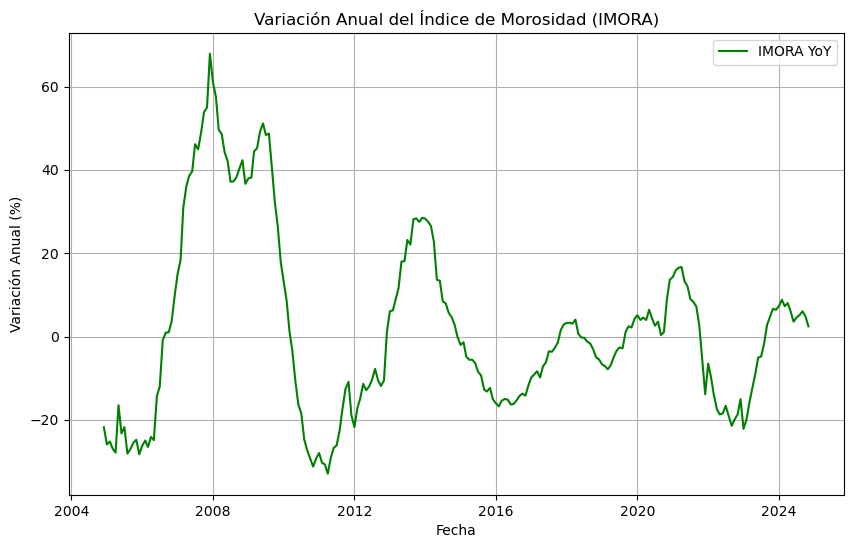

In [87]:
# Crear el gráfico
plt.figure(figsize=(12, 6))

plt.plot(serie_objetivo['Fecha'], serie_objetivo['Índice de Morosidad (IMORA)'], label="IMORA Original", color="skyblue") # IMORA original
plt.plot(serie_objetivo['Fecha'], serie_objetivo['IMORA_YoY_log'], label="Logarítmica Transformado", color="orangered", linestyle='--') # IMORA transformado Logarítmica
plt.plot(serie_objetivo['Fecha'], serie_objetivo['IMORA_YoY_boxcox'], label="Box-Cox Transformado", color="brown", linestyle='--') # IMORA transformado Box-Cox
plt.plot(serie_objetivo['Fecha'], serie_objetivo['IMORA_YoY_sqrt'], label="Raíz Cuadrada Transformado", color="orange", linestyle='--')# IMORA transformado Raíz Cuadrada

# Regresiones
plt.plot(serie_objetivo['Fecha'], serie_objetivo['IMORA_Predicho'], label="Tendencia Predicha (Regresión)", color="red", linestyle=':')# Tendencia lineal
plt.plot(serie_objetivo['Fecha'], serie_objetivo['IMORA_Predicho_Poly'], label="Tendencia Polinómica (Grado 2)", color="purple", linestyle=':') #

#Oulaires Crisis 2008 o Covid
for i, row in outliers.iterrows():
    plt.axvspan(row['Fecha'] - pd.Timedelta(days=15),  # Extender +/- 15 días para mejorar la visibilidad
                row['Fecha'] + pd.Timedelta(days=15), 
                color='gray', alpha=0.2, 
                label="Zona Gris: Outliers" if i == 0 else None)


plt.title("Evolución del Índice de Morosidad (IMORA) y sus Transformaciones")
plt.xlabel("Fecha")
plt.ylabel("Índice de Morosidad")
plt.legend()
plt.grid()

plt.show()

# Descomposición Estacional
decomposed = seasonal_decompose(serie_objetivo.set_index('Fecha')['Índice de Morosidad (IMORA)'], model='additive', period=12)
decomposed.plot()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(serie_objetivo['Fecha'], serie_objetivo['IMORA_YoY'], label="IMORA YoY", color="green")
plt.title("Variación Anual del Índice de Morosidad (IMORA)")
plt.xlabel("Fecha")
plt.ylabel("Variación Anual (%)")
plt.legend()
plt.grid()
plt.show()

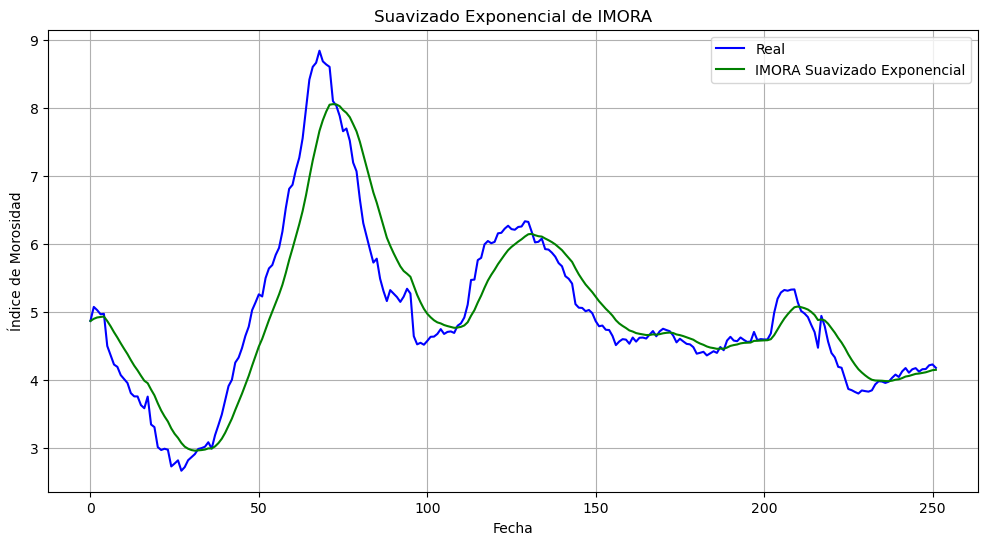

In [88]:
# Suavizado Exponencial
serie_objetivo['IMORA_suavizado_exp'] = serie_objetivo['Índice de Morosidad (IMORA)'].ewm(span=12, adjust=False).mean()

# Graficamos el IMORA original vs. el suavizado exponencial
plt.figure(figsize=(12,6))
plt.plot(serie_objetivo.index, serie_objetivo['Índice de Morosidad (IMORA)'], label='Real', color='blue')
plt.plot(serie_objetivo.index, serie_objetivo['IMORA_suavizado_exp'], label='IMORA Suavizado Exponencial', color='green')
plt.title('Suavizado Exponencial de IMORA')
plt.xlabel('Fecha')
plt.ylabel('Índice de Morosidad')
plt.legend()
plt.grid()
plt.show()


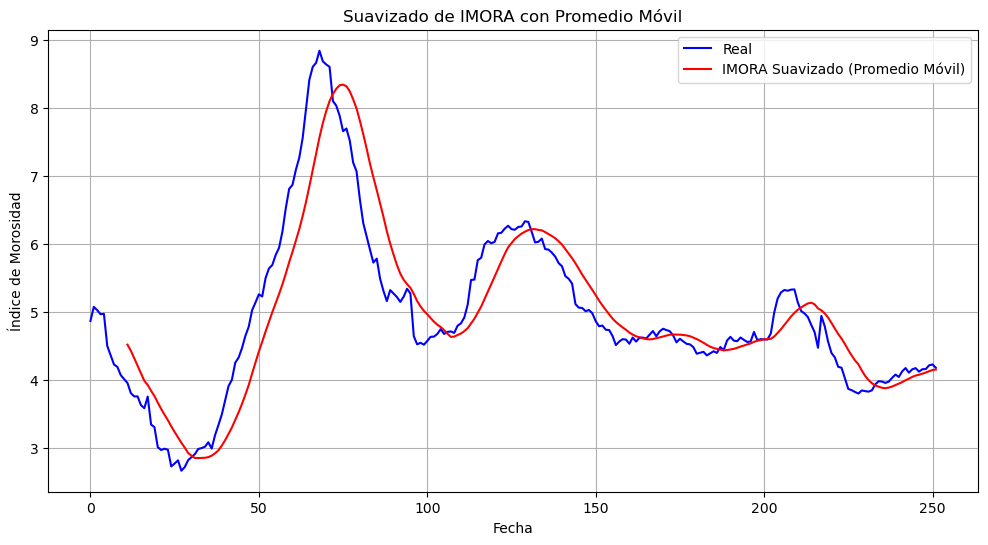

In [89]:
# Suavizado con Promedio Móvil
serie_objetivo['IMORA_suavizado'] = serie_objetivo['Índice de Morosidad (IMORA)'].rolling(window=12).mean()

# Graficamos el IMORA original vs. el suavizado
plt.figure(figsize=(12,6))
plt.plot(serie_objetivo.index, serie_objetivo['Índice de Morosidad (IMORA)'], label='Real', color='blue')
plt.plot(serie_objetivo.index, serie_objetivo['IMORA_suavizado'], label='IMORA Suavizado (Promedio Móvil)', color='red')
plt.title('Suavizado de IMORA con Promedio Móvil')
plt.xlabel('Fecha')
plt.ylabel('Índice de Morosidad')
plt.legend()
plt.grid()
plt.show()

#### Relacion con Variables externas (Correlacion)

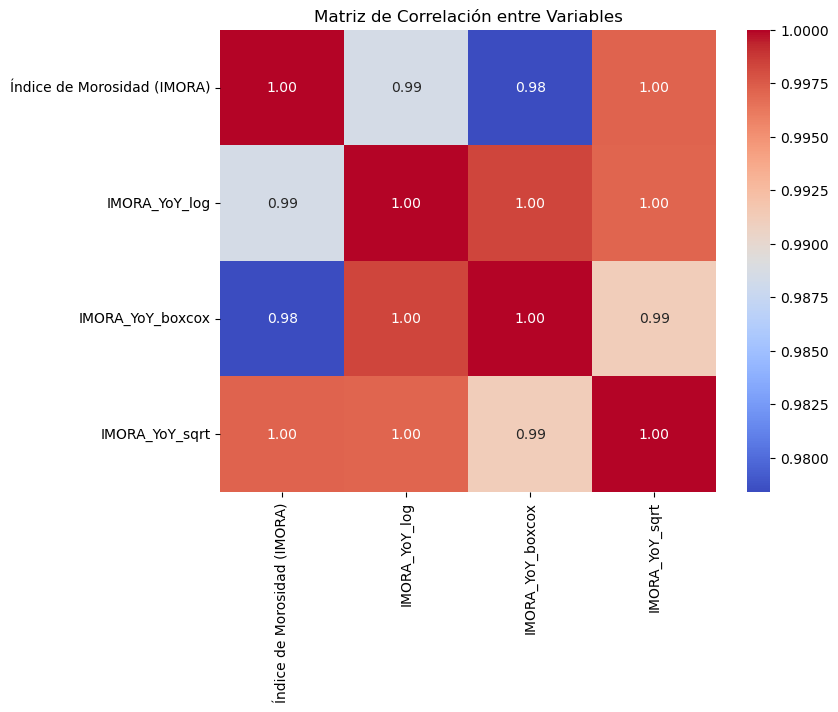

In [90]:
# Calcular la matriz de correlación
corr_matrix = serie_objetivo[['Índice de Morosidad (IMORA)', 'IMORA_YoY_log', 'IMORA_YoY_boxcox', 'IMORA_YoY_sqrt']].corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación entre Variables")
plt.show()


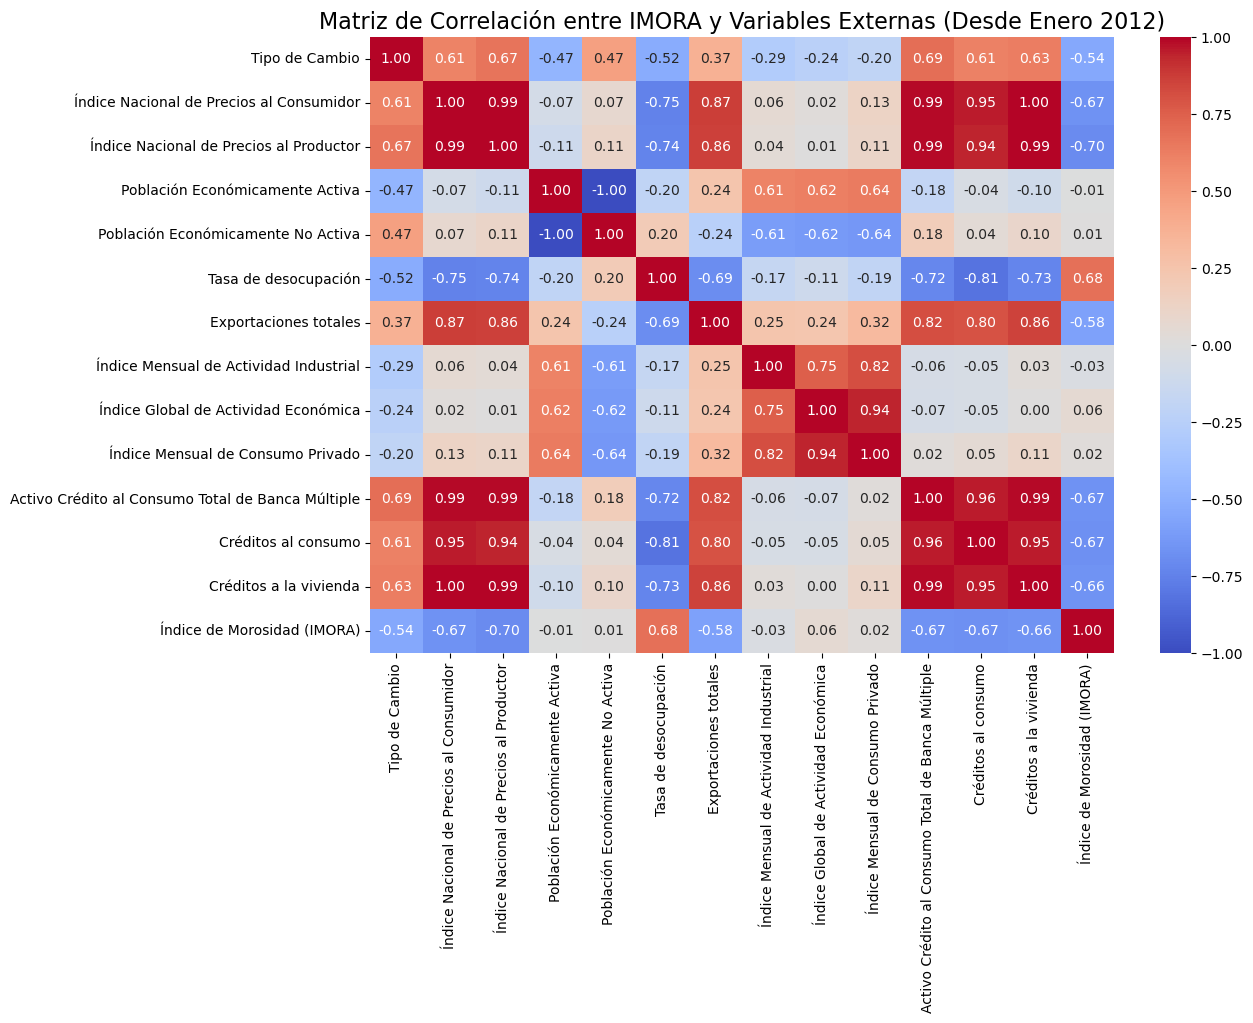

In [91]:
# Asegurarse de que 'Fecha' esté en formato datetime
VARIACION_MENSUAL['Fecha'] = pd.to_datetime(VARIACION_MENSUAL['Fecha'])
serie_objetivo['Fecha'] = pd.to_datetime(serie_objetivo['Fecha'])

# Filtrar los datos desde enero de 2012 para evitar sesgos de valores 0 
df_filtrado = VARIACION_MENSUAL[VARIACION_MENSUAL['Fecha'] >= '2012-01-01']


df_merged = pd.merge(df_filtrado, serie_objetivo[['Fecha', 'Índice de Morosidad (IMORA)']], on='Fecha', how='inner')
columnas_interes = ['Tipo de Cambio', 'Índice Nacional de Precios al Consumidor', 
                    'Índice Nacional de Precios al Productor', 'Población Económicamente Activa', 
                    'Población Económicamente No Activa', 'Tasa de desocupación', 
                    'Exportaciones totales', 'Índice Mensual de Actividad Industrial', 
                    'Índice Global de Actividad Económica', 'Índice Mensual de Consumo Privado', 
                    'Activo Crédito al Consumo Total de Banca Múltiple', 'Créditos al consumo', 
                    'Créditos a la vivienda', 'Índice de Morosidad (IMORA)']  # Añadir IMORA aquí

df_correlacion = df_merged[columnas_interes]
corr_matrix = df_correlacion.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, vmin=-1, vmax=1)
plt.title('Matriz de Correlación entre IMORA y Variables Externas (Desde Enero 2012)', fontsize=16)
plt.show()


In [92]:
# Obtener las correlaciones con IMORA
correlaciones = corr_matrix['Índice de Morosidad (IMORA)'].sort_values(ascending=False)

# Mostrar las variables más correlacionadas
print(correlaciones)


Índice de Morosidad (IMORA)                          1.000000
Tasa de desocupación                                 0.683729
Índice Global de Actividad Económica                 0.058090
Índice Mensual de Consumo Privado                    0.020420
Población Económicamente No Activa                   0.006042
Población Económicamente Activa                     -0.006042
Índice Mensual de Actividad Industrial              -0.030485
Tipo de Cambio                                      -0.541231
Exportaciones totales                               -0.582672
Créditos a la vivienda                              -0.663411
Activo Crédito al Consumo Total de Banca Múltiple   -0.668783
Índice Nacional de Precios al Consumidor            -0.670028
Créditos al consumo                                 -0.674731
Índice Nacional de Precios al Productor             -0.700200
Name: Índice de Morosidad (IMORA), dtype: float64


#### Preddiccion Futuro (ARIMA LSTM coon variables externas)

##### ARIMA

Variables seleccionadas (Top 5 por valor absoluto): ['Tasa de desocupación', 'Índice Mensual de Actividad Industrial', 'Exportaciones totales', 'Índice Mensual de Consumo Privado', 'Índice Global de Actividad Económica']


c:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


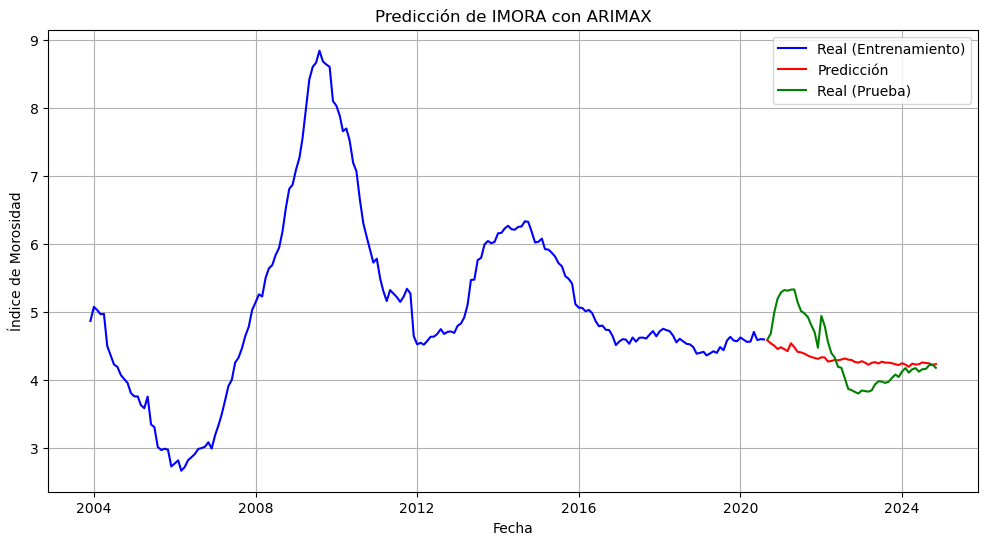

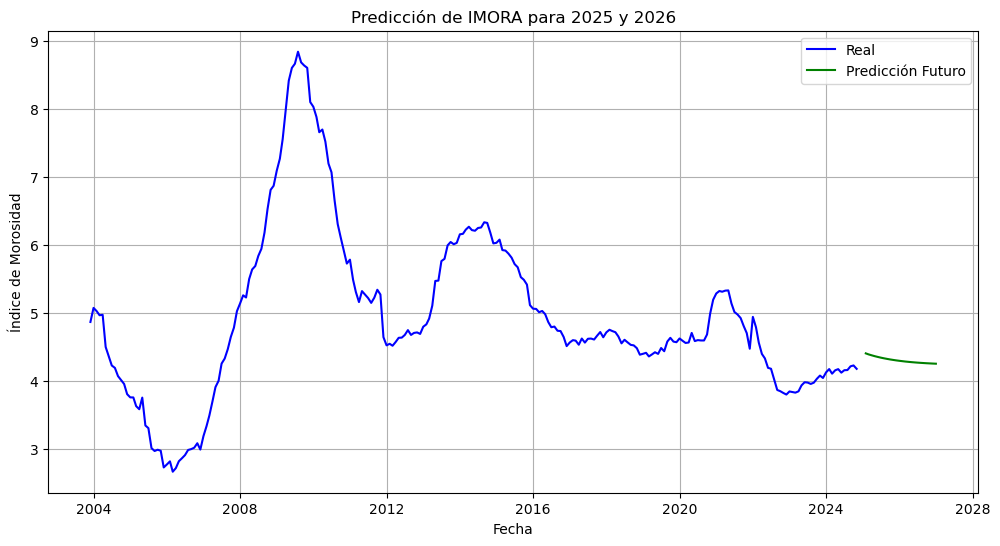

In [93]:
# Cargar la serie de IMORA y variables externas Mensuales
serie_objetivo = SERIE_OBJETIVO.sort_values(by='Fecha')
variables_externas = VARIACION_MENSUAL.sort_values(by='Fecha')
serie_objetivo['Fecha'] = pd.to_datetime(serie_objetivo['Fecha'])
serie_objetivo.set_index('Fecha', inplace=True)
variables_externas['Fecha'] = pd.to_datetime(variables_externas['Fecha'])
variables_externas.set_index('Fecha', inplace=True)

# Eliminar filas con valores 0 en las variables externas para evitar sesgo
variables_externas = variables_externas.loc[(variables_externas != 0).all(axis=1)]
variables_externas = variables_externas.loc[serie_objetivo.index]
variables_externas = variables_externas.fillna(variables_externas.mean())

# Correlaciones entre las variables externas y el IMORA
correlaciones = variables_externas.corrwith(serie_objetivo['Índice de Morosidad (IMORA)']).sort_values(ascending=False)

# Seleccionar las 5 variables con mayor correlación en valor absoluto
top_variables = correlaciones.abs().sort_values(ascending=False).head(5).index.tolist()
print("Variables seleccionadas (Top 5 por valor absoluto):", top_variables)

# Crear el conjunto de variables explicativas (X) y la variable dependiente (y)
X = variables_externas[top_variables]
y = serie_objetivo['Índice de Morosidad (IMORA)']

X = X.loc[y.index]

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar el modelo ARIMAX
model = ARIMA(y_train, exog=X_train_scaled, order=(1, 1, 1))
model_fit = model.fit()

# Realizar las predicciones sobre el conjunto de prueba
y_pred = model_fit.forecast(steps=len(X_test), exog=X_test_scaled)

# Graficar la predicción vs. la realidad
plt.figure(figsize=(12,6))

plt.plot(y_train.index, y_train, label='Real (Entrenamiento)', color='blue')
plt.plot(y_test.index, y_pred, label='Predicción', color='red')
plt.plot(y_test.index, y_test, label='Real (Prueba)', color='green')

plt.title('Predicción de IMORA con ARIMAX')
plt.xlabel('Fecha')
plt.ylabel('Índice de Morosidad')
plt.legend()
plt.grid()
plt.show()

# Predicción a futuro para 2 años
# Crear un DataFrame con las fechas futuras
fechas_futuras = pd.date_range(start='2025-01-01', end='2026-12-31', freq='M')
X_futuro = variables_externas[top_variables].reindex(fechas_futuras, method='ffill')

#Repetir modelo 
X_futuro = X_futuro.fillna(X_futuro.mean())
X_futuro_scaled = scaler.transform(X_futuro)
y_futuro_pred = model_fit.forecast(steps=len(X_futuro), exog=X_futuro_scaled) #prediccion

# Graficar la predicción futura
plt.figure(figsize=(12,6))
plt.plot(serie_objetivo.index, y, label='Real', color='blue')
plt.plot(fechas_futuras, y_futuro_pred, label='Predicción Futuro', color='green')
plt.title('Predicción de IMORA para 2025 y 2026')
plt.xlabel('Fecha')
plt.ylabel('Índice de Morosidad')
plt.legend()
plt.grid()
plt.show()

# Calcular la Variación Anual del IMORA
imora_anual = serie_objetivo['Índice de Morosidad (IMORA)'].pct_change(periods=12) * 100


In [94]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
print(f'Error Cuadrático Medio (MSE): {mse}')

rmse = np.sqrt(mse)
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse}')

mae = mean_absolute_error(y_test, y_pred)
print(f'Error Absoluto Medio (MAE): {mae}')

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'Error Absoluto Porcentual Medio (MAPE): {mape:.2f}%')

from sklearn.model_selection import TimeSeriesSplit

rango = serie_objetivo['Índice de Morosidad (IMORA)'].max() - serie_objetivo['Índice de Morosidad (IMORA)'].min()
print(f'Rango de IMORA: {rango}')

baseline_pred = [y_train.mean()] * len(y_test)
baseline_mse = mean_squared_error(y_test, baseline_pred)
print(f'MSE del modelo base: {baseline_mse}')


Error Cuadrático Medio (MSE): 0.17937631039055296
Raíz del Error Cuadrático Medio (RMSE): 0.42352840564778294
Error Absoluto Medio (MAE): 0.33948936258863416
Error Absoluto Porcentual Medio (MAPE): 7.44%
Rango de IMORA: 6.1735880000000005
MSE del modelo base: 0.7201207435783465


##### LSTM

Variables seleccionadas: ['Tasa de desocupación', 'Índice Mensual de Actividad Industrial', 'Exportaciones totales']


C:\Users\humberto.ortiz\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 27.8681 - val_loss: 18.7947
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 26.4164 - val_loss: 17.8714
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 25.7351 - val_loss: 16.3993
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 23.9989 - val_loss: 13.9021
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 20.0376 - val_loss: 9.7327
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 14.8155 - val_loss: 3.9659
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.2863 - val_loss: 0.2896
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.7372 - val_loss: 3.5395
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.8713 - val_loss: 1.9421
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.5203 - val_loss: 0.4155
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.4453 - val_loss: 0.2424
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.3222 - val_los

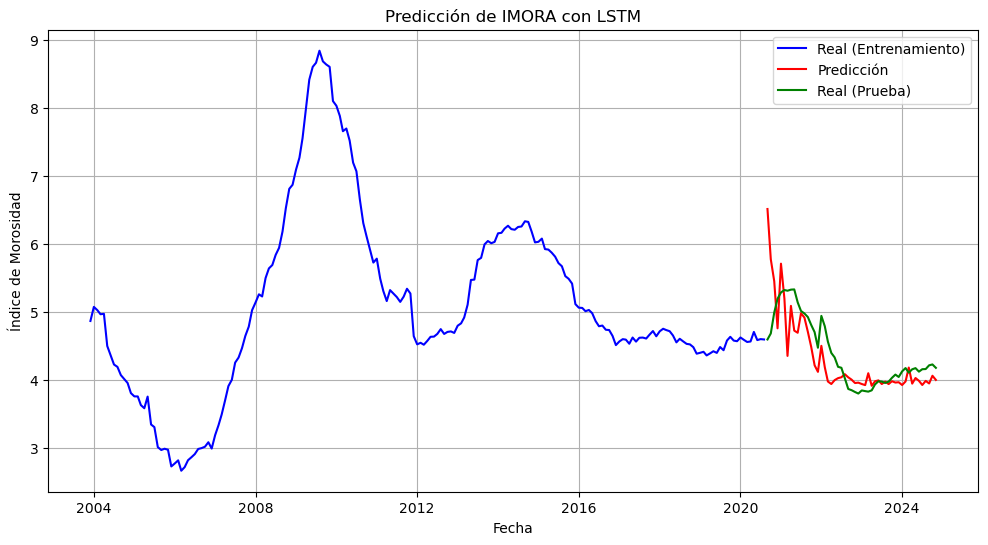

In [95]:
# Cargar la serie de IMORA y variables externas Mensuales
serie_objetivo = SERIE_OBJETIVO.sort_values(by='Fecha')
variables_externas = VARIACION_MENSUAL.sort_values(by='Fecha')
serie_objetivo['Fecha'] = pd.to_datetime(serie_objetivo['Fecha'])
serie_objetivo.set_index('Fecha', inplace=True)
variables_externas['Fecha'] = pd.to_datetime(variables_externas['Fecha'])
variables_externas.set_index('Fecha', inplace=True)

# Eliminar filas con valores 0 en las variables externas para evitar sesgo
variables_externas = variables_externas.loc[(variables_externas != 0).all(axis=1)]
variables_externas = variables_externas.loc[serie_objetivo.index]
variables_externas = variables_externas.fillna(variables_externas.mean())

# Calcular correlaciones entre las variables externas y el IMORA
correlaciones = variables_externas.corrwith(serie_objetivo['Índice de Morosidad (IMORA)']).sort_values(ascending=False)

# Seleccionar las variables con mayor correlación en valor absoluto
top_variables = correlaciones.abs().sort_values(ascending=False).head(3).index.tolist()

print("Variables seleccionadas:", top_variables)

# Crear el conjunto de variables explicativas (X) y la variable dependiente (y)
X = variables_externas[top_variables]
y = serie_objetivo['Índice de Morosidad (IMORA)']

# Asegurarnos de que las fechas estén alineadas en X e y
X = X.loc[y.index]

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Escalar las variables explicativas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reestructurar los datos para la red LSTM (3D)
def reshape_for_lstm(X):
    return np.array(X).reshape(X.shape[0], X.shape[1], 1)

X_train_lstm = reshape_for_lstm(X_train_scaled)
X_test_lstm = reshape_for_lstm(X_test_scaled)

# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Predicción de un valor (IMORA)

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test), verbose=1)

# Realizar predicciones sobre el conjunto de prueba
y_pred_lstm = model.predict(X_test_lstm)

# Graficar la predicción
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label='Real (Entrenamiento)', color='blue')
plt.plot(y_test.index, y_pred_lstm, label='Predicción', color='red')
plt.plot(y_test.index, y_test, label='Real (Prueba)', color='green')

plt.title('Predicción de IMORA con LSTM')
plt.xlabel('Fecha')
plt.ylabel('Índice de Morosidad')
plt.legend()
plt.grid()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


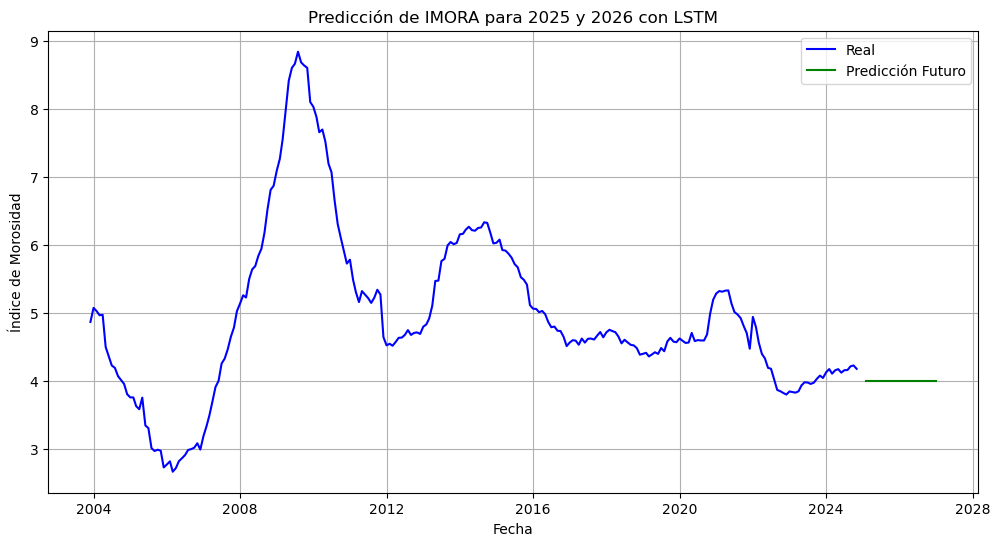

In [96]:
# Predicción a futuro para prximos dos años
fechas_futuras = pd.date_range(start='2025-01-01', end='2026-12-31', freq='M')
X_futuro = variables_externas[top_variables].reindex(fechas_futuras, method='ffill')


X_futuro = X_futuro.fillna(X_futuro.mean())
X_futuro_scaled = scaler.transform(X_futuro)

# Reestructurar los datos para la red LSTM
X_futuro_lstm = reshape_for_lstm(X_futuro_scaled)

# Realizar la predicción futura
y_futuro_pred_lstm = model.predict(X_futuro_lstm)

# Graficar la predicción futura
plt.figure(figsize=(12,6))
plt.plot(serie_objetivo.index, y, label='Real', color='blue')
plt.plot(fechas_futuras, y_futuro_pred_lstm, label='Predicción Futuro', color='green')
plt.title('Predicción de IMORA para 2025 y 2026 con LSTM')
plt.xlabel('Fecha')
plt.ylabel('Índice de Morosidad')
plt.legend()
plt.grid()
plt.show()

##### Prediccion LSTM Suavizadas

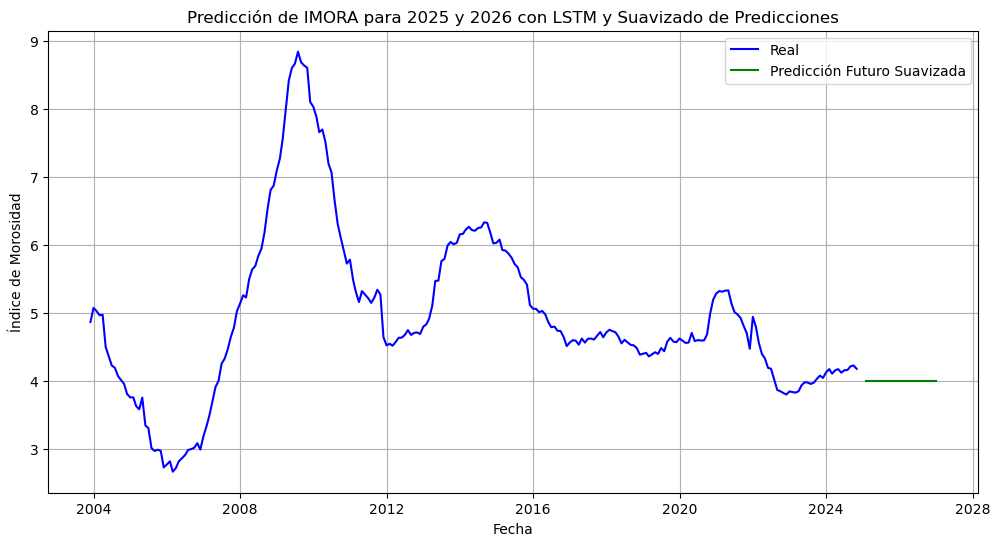

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


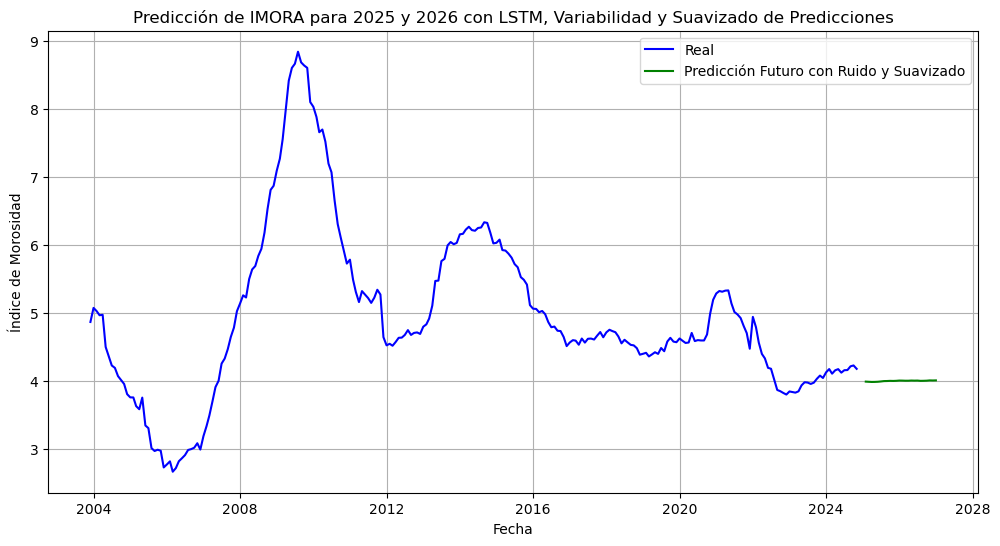

In [97]:
# Suavizado de las predicciones para evitar que todas sean iguales
def suavizar_predicciones(predicciones, span=12):
    # Suavizado exponencial de las predicciones
    return pd.Series(predicciones.flatten()).ewm(span=span, adjust=False).mean()

# Suavizamos las predicciones para el futuro
y_futuro_pred_lstm_suavizado = suavizar_predicciones(y_futuro_pred_lstm)

# Graficar las predicciones suavizadas
plt.figure(figsize=(12,6))
plt.plot(serie_objetivo.index, serie_objetivo['Índice de Morosidad (IMORA)'], label='Real', color='blue')
plt.plot(fechas_futuras, y_futuro_pred_lstm_suavizado, label='Predicción Futuro Suavizada', color='green')
plt.title('Predicción de IMORA para 2025 y 2026 con LSTM y Suavizado de Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Índice de Morosidad')
plt.legend()
plt.grid(True)
plt.show()

# Generar variabilidad en las variables futuras para evitar que el modelo las vea como constantes
X_futuro_variabilidad = X_futuro.copy()

# Añadir variabilidad aleatoria (ruido) a las variables
import numpy as np
np.random.seed(42)  # Para reproducibilidad
ruido = np.random.normal(0, 0.1, size=X_futuro_variabilidad.shape)  # Añadir ruido con pequeña desviación

X_futuro_variabilidad += ruido  # Incorporar ruido

# Reescalar las variables con ruido
X_futuro_variabilidad_scaled = scaler.transform(X_futuro_variabilidad)

# Reestructurar para LSTM
X_futuro_variabilidad_lstm = reshape_for_lstm(X_futuro_variabilidad_scaled)

# Realizar la predicción futura con las variables modificadas
y_futuro_pred_lstm_variabilidad = model.predict(X_futuro_variabilidad_lstm)

# Suavizar las predicciones con ruido
y_futuro_pred_lstm_variabilidad_suavizado = suavizar_predicciones(y_futuro_pred_lstm_variabilidad)

# Graficar las predicciones 
plt.figure(figsize=(12,6))
plt.plot(serie_objetivo.index, serie_objetivo['Índice de Morosidad (IMORA)'], label='Real', color='blue')
plt.plot(fechas_futuras, y_futuro_pred_lstm_variabilidad_suavizado, label='Predicción Futuro con Ruido y Suavizado', color='green')
plt.title('Predicción de IMORA para 2025 y 2026 con LSTM, Variabilidad y Suavizado de Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Índice de Morosidad')
plt.legend()
plt.grid(True)
plt.show()



#### Prediccion a dos años sin variables externas

Estadístico ADF: -3.5897598117918137
Valor p: 0.005959843093343476
La serie es estacionaria.


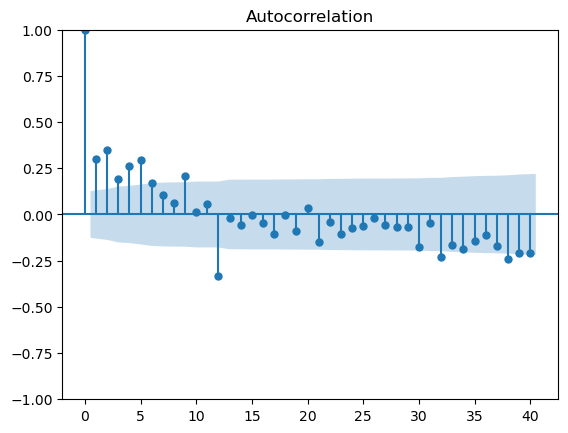

c:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


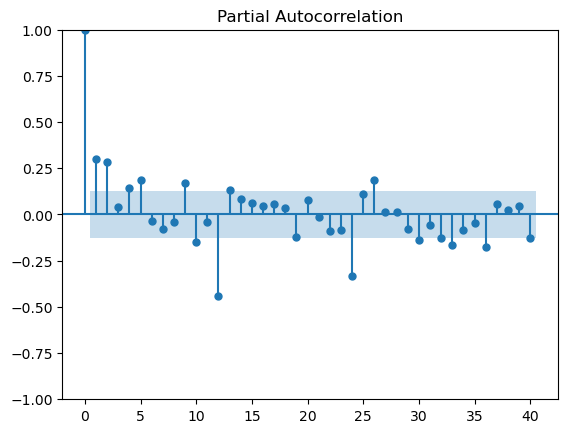

c:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


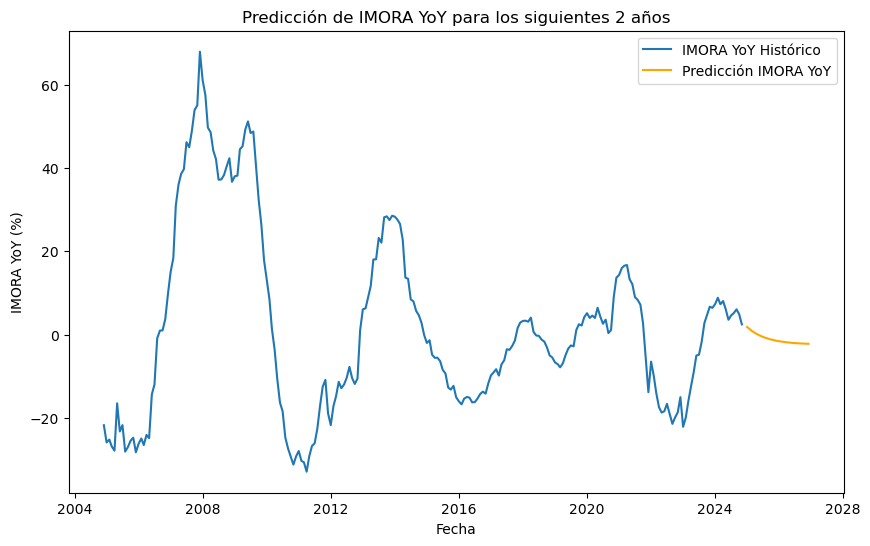

In [98]:
serie_objetivo = SERIE_OBJETIVO.sort_values(by='Fecha')
serie_objetivo['Fecha'] = pd.to_datetime(serie_objetivo['Fecha'])  
serie_objetivo.set_index('Fecha', inplace=True)  
serie_objetivo['IMORA_YoY'] = serie_objetivo['Índice de Morosidad (IMORA)'].pct_change(periods=12) * 100  # Variación anual

# Verificación de estacionariedad
def test_stationarity(series):
    result = adfuller(series.dropna())  # Realizamos la prueba de Dickey-Fuller
    print(f"Estadístico ADF: {result[0]}")
    print(f"Valor p: {result[1]}")
    if result[1] > 0.05:
        print("La serie no es estacionaria, se requiere diferenciación.")
    else:
        print("La serie es estacionaria.")

test_stationarity(serie_objetivo['IMORA_YoY'])

# Si la serie no es estacionaria, diferenciamos la serie
serie_objetivo['IMORA_YoY_diff'] = serie_objetivo['IMORA_YoY'].diff().dropna()

# ACF y PACF para determinar p, d, q
plot_acf(serie_objetivo['IMORA_YoY_diff'].dropna(), lags=40)
plt.show()
plot_pacf(serie_objetivo['IMORA_YoY_diff'].dropna(), lags=40)
plt.show()

# ARIMA
model = ARIMA(serie_objetivo['IMORA_YoY'], order=(1,1,1))  # Establecer los parámetros p, d, q
model_fit = model.fit()

# Predicción para los siguientes 2 años
forecast = model_fit.forecast(steps=24)
forecast_dates = pd.date_range(serie_objetivo.index.max(), periods=25, freq='M')[1:]

forecast_df = pd.DataFrame({'Fecha': forecast_dates, 'Predicción IMORA_YoY': forecast})

# Graficar la predicción
plt.figure(figsize=(10,6))
plt.plot(serie_objetivo.index, serie_objetivo['IMORA_YoY'], label='IMORA YoY Histórico')
plt.plot(forecast_df['Fecha'], forecast_df['Predicción IMORA_YoY'], label='Predicción IMORA YoY', color='orange')
plt.title('Predicción de IMORA YoY para los siguientes 2 años')
plt.xlabel('Fecha')
plt.ylabel('IMORA YoY (%)')
plt.legend()
plt.show()


In [99]:
#Validacion de resultados
serie_objetivo = SERIE_OBJETIVO.sort_values(by='Fecha')
serie_objetivo['Fecha'] = pd.to_datetime(serie_objetivo['Fecha'])
serie_objetivo.set_index('Fecha', inplace=True)
serie_objetivo['IMORA_YoY'] = serie_objetivo['Índice de Morosidad (IMORA)'].pct_change(periods=12) * 100

# Separar datos en entrenamiento y validación
entrenamiento = serie_objetivo[serie_objetivo.index.year < 2024]['Índice de Morosidad (IMORA)']
validacion = serie_objetivo[serie_objetivo.index.year == 2024]['Índice de Morosidad (IMORA)']

#modelo ARIM
modelo_arima = ARIMA(entrenamiento, order=(1, 1, 1))  # Cambia los parámetros (p, d, q) según corresponda
resultado = modelo_arima.fit()

# pronóstico para 2024
pronostico_2024 = resultado.forecast(steps=len(validacion))

#MAPE
mape = mean_absolute_percentage_error(validacion, pronostico_2024)
print(f"\nError porcentual absoluto promedio (MAPE): {mape * 100:.2f}%")


c:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



Error porcentual absoluto promedio (MAPE): 2.05%
